In [1]:
# Import all necessary libraries 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_selection import SelectKBest, mutual_info_classif

#import warnings
#warnings.filterwarnings("ignore")

# Data Exploration

In [2]:
# Load data
data = pd.read_csv("./dataset.csv")
data = data.astype(int)
data

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0,1,1,1,45,0,0,0,0,1,...,1,0,3,0,5,0,1,5,6,7
253676,2,1,1,1,18,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,0,1,28,0,0,0,1,1,...,1,0,1,0,0,0,0,2,5,2
253678,0,1,0,1,23,0,0,0,0,1,...,1,0,3,0,0,0,1,7,5,1


### Data types exploration

In [3]:
data_types = data.dtypes
data_types

Diabetes_012            int64
HighBP                  int64
HighChol                int64
CholCheck               int64
BMI                     int64
Smoker                  int64
Stroke                  int64
HeartDiseaseorAttack    int64
PhysActivity            int64
Fruits                  int64
Veggies                 int64
HvyAlcoholConsump       int64
AnyHealthcare           int64
NoDocbcCost             int64
GenHlth                 int64
MentHlth                int64
PhysHlth                int64
DiffWalk                int64
Sex                     int64
Age                     int64
Education               int64
Income                  int64
dtype: object

# Data preprocessing and visualisation

### Dublicates. Missing Values and Outliers

In [4]:
#check data's integrity
data.duplicated()
int(data.duplicated().sum())


23899

This are a lot of duplicates but I assume that this happens verry quick, even if it is really a different patient, with such a huge amount of categorical 2 group variables. Because of this it would be bad to drop dublicates and keep respectively the first of them.

In [5]:
#check for missing values
data.isna().sum(axis=1)
data.isna().any(axis=1).any()

np.False_

<- no missing values

Features and Label

In [6]:
X=data.drop(['Diabetes_012'], axis=1)
y=data['Diabetes_012']
X.shape

(253680, 21)

Compute correlation matrix

In [7]:
corr_matrix = X.corr().abs() #abs trat negative values same as positive
corr_matrix

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
HighBP,1.000000,0.298199,0.098508,0.213748,0.096991,0.129575,0.209361,0.125267,0.040555,0.061266,...,0.038425,0.017358,0.300530,0.056456,0.161212,0.223618,0.052207,0.344452,0.141358,0.171235
HighChol,0.298199,1.000000,0.085642,0.106722,0.091299,0.092620,0.180765,0.078046,0.040859,0.039874,...,0.042230,0.013310,0.208426,0.062069,0.121751,0.144672,0.031205,0.272318,0.070802,0.085459
CholCheck,0.098508,0.085642,1.000000,0.034495,0.009929,0.024158,0.044206,0.004190,0.023849,0.006121,...,0.117626,0.058255,0.046589,0.008366,0.031775,0.040585,0.022115,0.090321,0.001510,0.014259
BMI,0.213748,0.106722,0.034495,1.000000,0.013804,0.020153,0.052904,0.147294,0.087518,0.062275,...,0.018471,0.058206,0.239185,0.085310,0.121141,0.197078,0.042950,0.036618,0.103932,0.100069
Smoker,0.096991,0.091299,0.009929,0.013804,1.000000,0.061173,0.114441,0.087401,0.077666,0.030678,...,0.023251,0.048946,0.163143,0.092196,0.116460,0.122463,0.093662,0.120641,0.161955,0.123937
Stroke,0.129575,0.092620,0.024158,0.020153,0.061173,1.000000,0.203002,0.069151,0.013389,0.041124,...,0.008776,0.034804,0.177942,0.070172,0.148944,0.176567,0.002978,0.126974,0.076009,0.128599
HeartDiseaseorAttack,0.209361,0.180765,0.044206,0.052904,0.114441,0.203002,1.000000,0.087299,0.019790,0.039167,...,0.018734,0.031000,0.258383,0.064621,0.181698,0.212709,0.086096,0.221618,0.099600,0.141011
PhysActivity,0.125267,0.078046,0.004190,0.147294,0.087401,0.069151,0.087299,1.000000,0.142756,0.153150,...,0.035505,0.061638,0.266186,0.125587,0.219230,0.253174,0.032482,0.092511,0.199658,0.198539
Fruits,0.040555,0.040859,0.023849,0.087518,0.077666,0.013389,0.019790,0.142756,1.000000,0.254342,...,0.031544,0.044243,0.103854,0.068217,0.044633,0.048352,0.091175,0.064547,0.110187,0.079929
Veggies,0.061266,0.039874,0.006121,0.062275,0.030678,0.041124,0.039167,0.153150,0.254342,1.000000,...,0.029584,0.032232,0.123066,0.058884,0.064290,0.080506,0.064765,0.009771,0.154329,0.151087


Plot correlation matrix

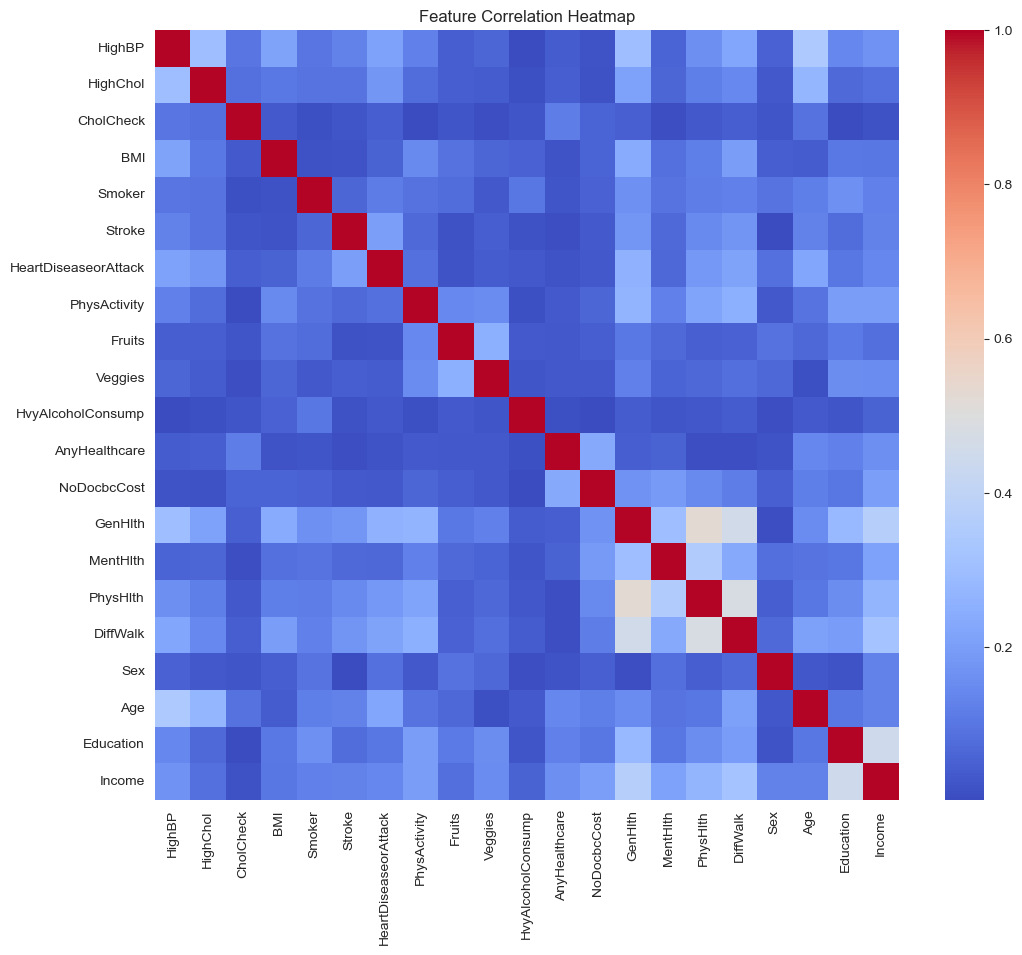

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()

Remove higly correlated variables

In [9]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.9 (threshold is adjustable)
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop redundant features
X_reduced = X.drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")

Removed 0 highly correlated features: []


Use mutual information filter methods to quantify the amount of information that one variable provides about another

In [10]:
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_new = selector.fit_transform(X, y)

Let's try backword stepwise elimination (with multinominal logistische regression)

In [12]:
import statsmodels.api as sm

#Add constant for intercept
def multinomial(X): 
    X = sm.add_constant(X)
    cols = list(X.columns)
    pmax = 1

    while len(cols) > 0:
        # Inside your while loop:
        model = sm.MNLogit(y, X[cols]).fit(disp=0)

        # Take max p-value per feature across classes
        p_values = model.pvalues
        p_values_max = p_values.max(axis=1)
        pmax = p_values_max.max()
        feature_with_p_max = p_values_max.idxmax()

        # Backward elimination step
        if pmax > 0.05:
            print(f"Dropping '{feature_with_p_max}' with p = {pmax:.4f}")
            cols.remove(feature_with_p_max)
        else:
            break

    print(f"Selected features: {cols}")
    return cols

multinomial(X)


Dropping 'PhysActivity' with p = 0.7308
Dropping 'DiffWalk' with p = 0.5998
Dropping 'Smoker' with p = 0.5562
Dropping 'HeartDiseaseorAttack' with p = 0.5250
Dropping 'Fruits' with p = 0.4939
Dropping 'AnyHealthcare' with p = 0.2242
Dropping 'NoDocbcCost' with p = 0.1240
Dropping 'Veggies' with p = 0.1182
Dropping 'Stroke' with p = 0.0915
Selected features: ['const', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income']


['const',
 'HighBP',
 'HighChol',
 'CholCheck',
 'BMI',
 'HvyAlcoholConsump',
 'GenHlth',
 'MentHlth',
 'PhysHlth',
 'Sex',
 'Age',
 'Education',
 'Income']

LABEL, CATEGORICAL AND NUMERICAL FEATURES

**Numerical (Interval data** <- has no meaningful zero **) :** 
BMI

**Categorical (Ordinal data) :**
Diabetes_012, Age, GenHlth, MentHlth, PhyaHlth, Education, Income) 

**Categorical (Nominal data) :** Rest 
-> (HighBP, HighChol, CholCheck, Smoker, Stroke, HeartDiseaseorAttack, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, DiffWalk, Sex) 

In [13]:
label = ['Diabetes_012']
num_cols = ['BMI', 'Age']
cate_cols = data.columns.drop(['BMI', 'Age', 'Diabetes_012'])

### Data Visualisation

Distribution label Diabetes:

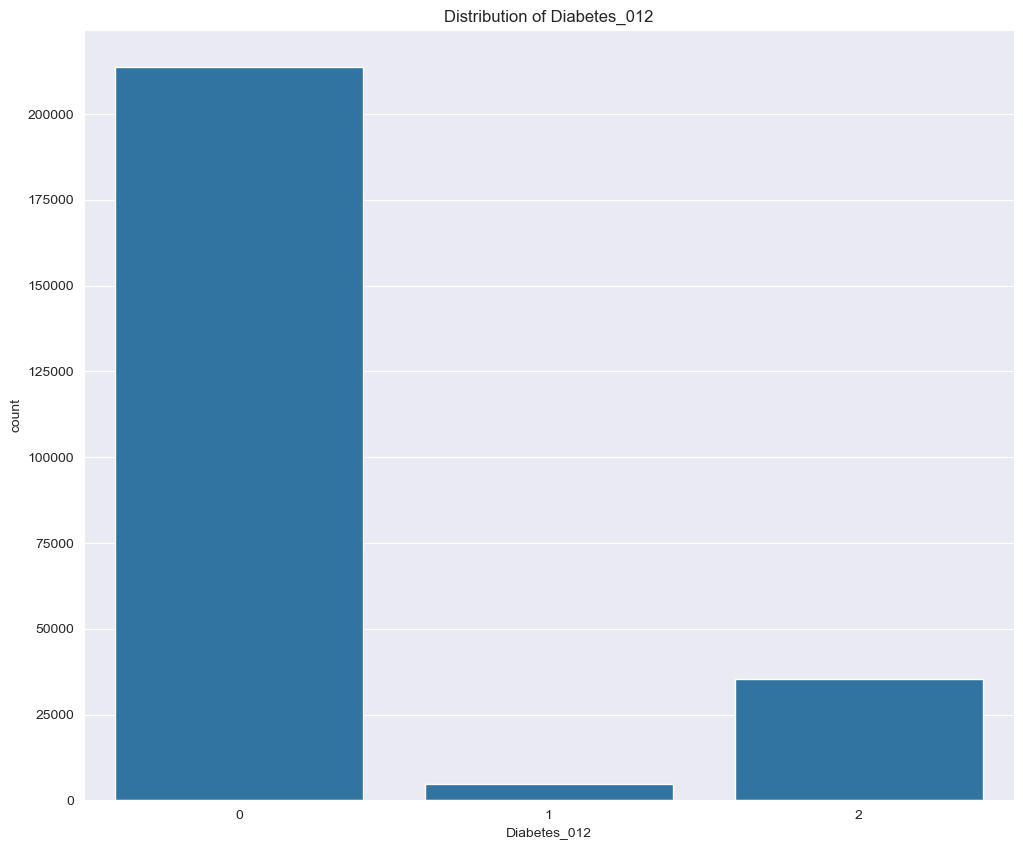

In [14]:
plt.figure(figsize=(12, 10))
sns.countplot(data=data, x='Diabetes_012')
plt.title('Distribution of Diabetes_012')
plt.show()

For the numerical features. See if there is a difference between Diabetes_012

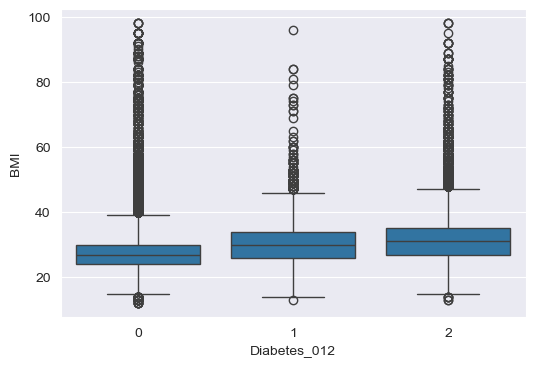

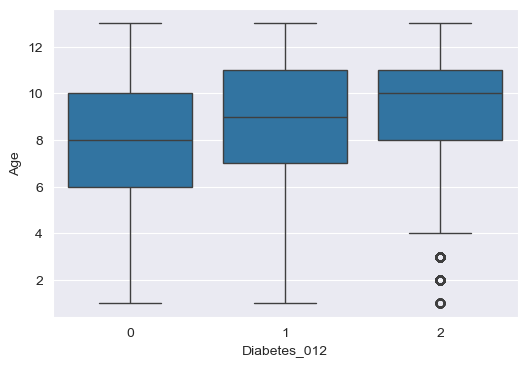

In [15]:
for i in range(len(num_cols)):
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, x='Diabetes_012', y=num_cols[i])
    plt.show()

Many outliers in BMI?

In [16]:
#Suggestion from Noemi:


➡ **Box Plot:** Use a box plot to show the data distribution and identify **outliers**. This type of chart works well when you have a lot of data and want to see the range and median of the data. A box-and-whisker plot displays the summary of a set of data:  the minimum, first quartile, median, third quartile, and maximum of the data subset. 

➡**Violin plots**: Use a box plot to visualize distribution and probability.  This hybrid chart works  version to shows the full distribution of the data and the peaks in the numeric dataset.  

➡ **Bar Chart:** Use a bar chart to compare categories or groups. This chart type works well when the data is discrete and not continuous.

Look at the distribution of every categorical variable

KeyboardInterrupt: 

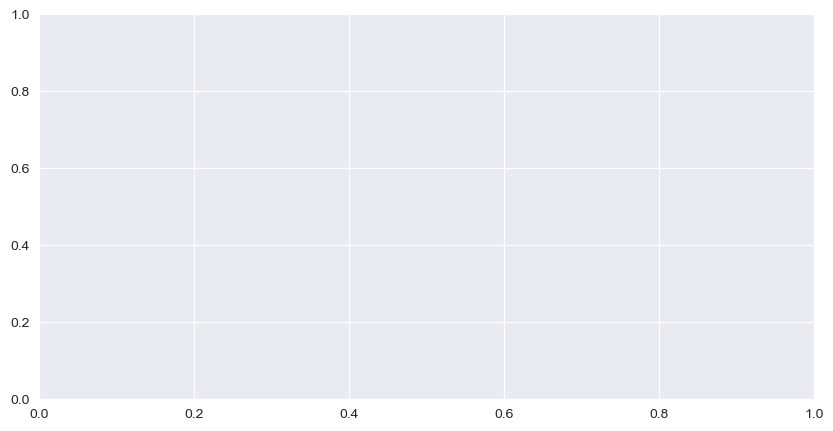

In [17]:
for col in cate_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data, x=col, hue='Diabetes_012')
    plt.title(f'{col} vs Diabetes')
    plt.show()


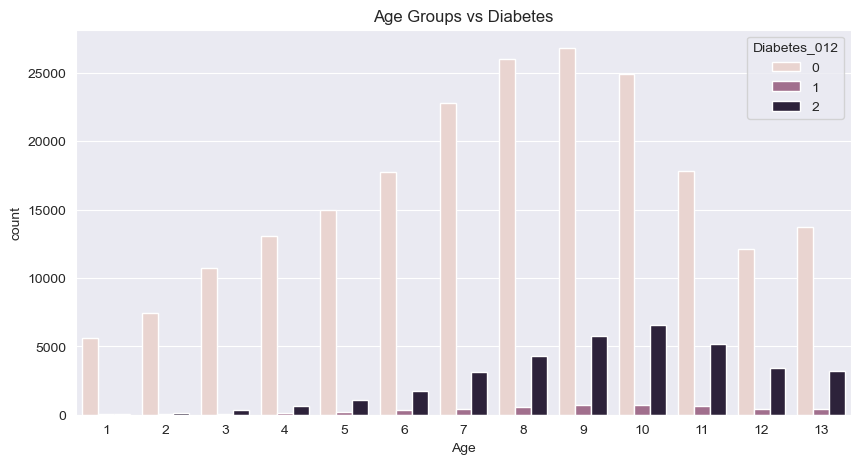

In [18]:
#for age as a categorical variable
plt.figure(figsize=(10, 5))
sns.countplot(data=data, x='Age', hue='Diabetes_012')
plt.title('Age Groups vs Diabetes')
plt.show()

 

# Machine Learning Algorithms

## Logistic Regression

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [23]:
# === 2. Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

Feature Selection (SelectKBest with tuning)

In [30]:
# === initialize dataframe for readout ===
kbest_df = pd.DataFrame({"Selected Feature": [],
            "Accuracy" : [],
            'Precision': [],
            'Recall':    [],
            'F1 Score':  []})
# === Feature selection with selectKbest ===
for i in range(1,22):
    selector = SelectKBest(score_func=mutual_info_classif,k=i)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    # (Optional) See selected feature names
    selected_features = X.columns[selector.get_support()]
    #print(" === Selected Features: ===")
    #print(selected_features)

    # === 4. Scale the features ===
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # === 5. Logistic Regression with balanced class weights ===
    lr = LogisticRegression(C=0.01,
                            penalty='l2',
                            solver='lbfgs',
                            class_weight='balanced',
                            max_iter=100)
    lr.fit(X_train_scaled, y_train)
    y_pred = lr.predict(X_test_scaled)

    # === 6. Evaluate ===
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    #kbest_df.loc[i, "Selected Feature"] = str(selected_features)
    kbest_df.loc[i, "Accuracy"] = accuracy
    kbest_df.loc[i, 'Precision'] = precision
    kbest_df.loc[i, 'Recall'] = recall
    kbest_df.loc[i, 'F1 Score'] = f1
kbest_df

,Selected Feature,Accuracy,Precision,Recall,F1 Score
1,NaN,0.554360,0.426507,0.460025,0.374199
2,NaN,0.606216,0.423613,0.483322,0.398417
3,NaN,0.604797,0.424670,0.483680,0.398643
4,NaN,0.604797,0.424670,0.483680,0.398643
5,NaN,0.625374,0.426207,0.491350,0.406313
6,NaN,0.630657,0.427074,0.492655,0.408639
7,NaN,0.630006,0.427002,0.492319,0.408354
8,NaN,0.647706,0.434550,0.506714,0.420232
9,NaN,0.647272,0.434493,0.506309,0.420024
10,NaN,0.647390,0.441990,0.515193,0.425231


Feature Selection (SelectFromModel)

In [29]:
# STEP 2: Scale the features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 3: Feature selection using SelectFromModel with Logistic Regression
selector_model = LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    solver='saga',
    max_iter=1000)

selector = SelectFromModel(estimator=selector_model)
selector.fit(X_train_scaled, y_train)

X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# STEP 4: Train a new model using selected features
final_model = LogisticRegression(
    class_weight='balanced',
    penalty='l2',
    solver='saga',
    max_iter=2000,
    random_state=42
)
final_model.fit(X_train_selected, y_train)

# STEP 5: Predict and evaluate
y_pred = final_model.predict(X_test_selected)

# === 6. Evaluate ===
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

# Optional: Detailed class-wise report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.6457544938505203
Precision (macro): 0.4436835676855276
Recall (macro): 0.5143033936459845
F1-score (macro): 0.42564447720646875

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.66      0.78     42741
           1       0.03      0.28      0.05       926
           2       0.35      0.60      0.45      7069

    accuracy                           0.65     50736
   macro avg       0.44      0.51      0.43     50736
weighted avg       0.85      0.65      0.72     50736



first try

 === Selected Features: ===
Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

 === Logistic Regression Evaluation: ===
Accuracy:  0.6458
Precision: 0.4456
Recall:    0.5242
F1 Score:  0.4269

 === Classification Report: ===
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     42741
           1       0.03      0.33      0.06       926
           2       0.35      0.58      0.44      7069

    accuracy                           0.65     50736
   macro avg       0.45      0.52      0.43     50736
weighted avg       0.85      0.65      0.72     50736


 === Confusion Matrix: ===


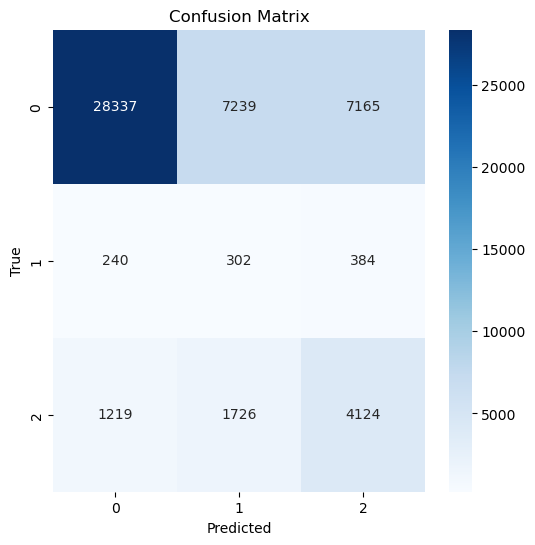

In [ ]:
# === 3. Feature selection ===
# Select top 15 features based on ANOVA F-value
selector = SelectKBest(k=21)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# (Optional) See selected feature names
selected_features = X.columns[selector.get_support()]
print(" === Selected Features: ===")
print(selected_features)

# === 4. Scale the features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# === 5. Logistic Regression with balanced class weights ===
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=100,
    random_state=42
)
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# === 6. Evaluate ===
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("\n === Logistic Regression Evaluation: ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

print("\n === Classification Report: ===")
print(classification_report(y_test, y_pred))

# === 7. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)

print("\n === Confusion Matrix: ===")
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Hyperparameter tuning

In [ ]:

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['elasticnet'],
    'solver': ['saga'],  # Must match penalty type
    'class_weight': ['balanced'],
    'max_iter': [100],
    'l1_ratio': [0.5]
}

lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=4, scoring='f1_macro')
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sandr\anaconda3\envs\jupyter\Lib\sit

Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
Best F1 score: 0.4267209936502767


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # Must match penalty typ
    'class_weight': ['balanced'],
    'max_iter': [100, 500, 1000]
}

lr = LogisticRegression()
grid = GridSearchCV(lr, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 score: 0.42668487985986403


## Decision Tree

In [19]:
# let's go

## Random Forest

Selected features: Index(['HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack', 'PhysActivity',
       'Fruits', 'GenHlth', 'DiffWalk', 'Sex', 'Age'],
      dtype='object')


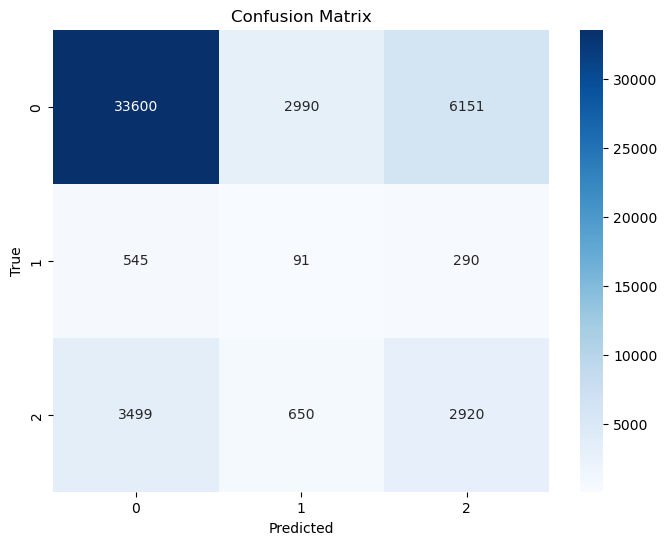

Random Forest Classifier
Accuracy: 0.7215980763166193
Precision: 0.7958269916916936
Recall: 0.7215980763166193
F1 Score: 0.7544807105045531
Log Loss: 1.3601759313496093
Cohen Kappa Score: 0.19978934304774798


In [21]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             log_loss, cohen_kappa_score, classification_report, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Split the data into training and testing sets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Select the features
rdf_selector = SelectKBest(score_func=mutual_info_classif, k=10)
rdf_selector.fit(X_scaled, y)
X_rdf= rdf_selector.transform(X_scaled)
selected_features = X.columns[rdf_selector.get_support()]

print("Selected features:", selected_features)

# Create a dataframe with the selected features
X_selected_rdf = pd.DataFrame(X_rdf, columns=selected_features, index=data.index)

# RANDOM FOREST
rdf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Split training/test
X_train, X_test, y_train, y_test = train_test_split(X_selected_rdf, y, test_size=0.2, random_state=42, stratify=y)

# Fit the model
rdf.fit(X_train, y_train)

# Prediction
y_pred = rdf.predict(X_test)
y_pred_proba = rdf.predict_proba(X_test)
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Evaluation
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Log Loss:", log_loss(y_test, y_pred_proba, labels=[0, 1, 2]))
print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred))



## Lightgbm

In [23]:
print(y.value_counts(normalize=True)) ##High imbalance --> Oversampling 

Diabetes_012
0    0.842412
2    0.139333
1    0.018255
Name: proportion, dtype: float64


Dropping 'PhysActivity' with p = 0.7308
Dropping 'DiffWalk' with p = 0.5998
Dropping 'Smoker' with p = 0.5562
Dropping 'HeartDiseaseorAttack' with p = 0.5250
Dropping 'Fruits' with p = 0.4939
Dropping 'AnyHealthcare' with p = 0.2242
Dropping 'NoDocbcCost' with p = 0.1240
Dropping 'Veggies' with p = 0.1182
Dropping 'Stroke' with p = 0.0915
Selected features: ['const', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income']
Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 512886, number of used features: 12
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -

C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\noah

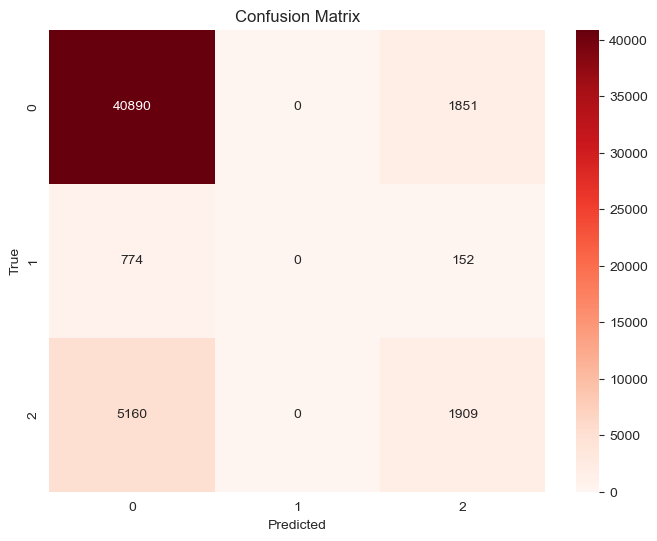

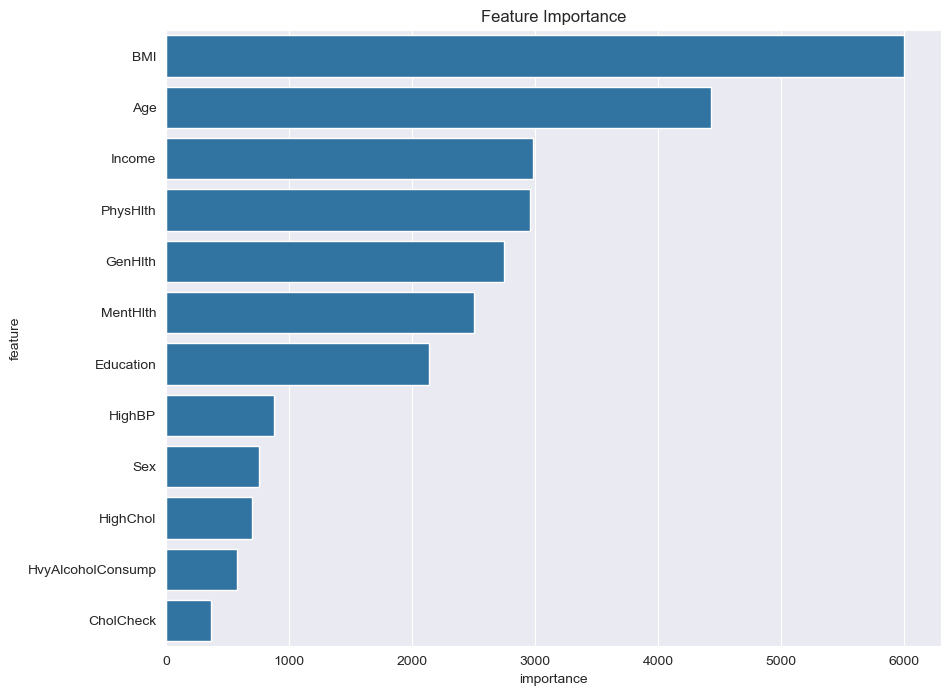

In [23]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, cohen_kappa_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter
# ==== Preprocessing ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# ==== Selezione delle migliori features ====
selected_cols = multinomial(X_scaled_df)
if 'const' in selected_cols:
    selected_cols.remove('const')
X_model = X_scaled_df[selected_cols]

# ==== Train/test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, stratify=y, random_state=42
)

# ==== Oversampling SMOTE ====
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# ==== Calcolo class_weight ====
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_bal), y=y_train_bal)
class_weight_dict = dict(zip(np.unique(y_train_bal), class_weights))
print("Class weights:", class_weight_dict)

# ==== Modello LightGBM ====
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    learning_rate=0.05,
    n_estimators=300,
    class_weight=class_weight_dict,
    random_state=42
)
model.fit(
    X_train_bal, y_train_bal,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(50)]
)

# ==== Predizioni ====
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)

# ==== Valutazione ====
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, digits=4))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall (macro): {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred):.4f}")

# ==== Confusion Matrix ====
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ==== Feature Importance ====
importance = model.feature_importances_
feature_names = X_model.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

## Multiclass Classification Neural Network

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# ==== 2. SPLIT TRAIN/TEST ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 3. SCALING ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==== 4. SMOTE RESAMPLING ====
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)

# ==== 5. CUSTOM DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values if isinstance(y, pd.Series) else y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ==== 6. MODEL DEFINITION ====
class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)

# ==== 7. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt

# ==== 8. MODEL SETUP ====
model = DiabetesModel(X.shape[1])

# Compute class weights based on inverse frequency (from resampled training set)
class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 9. TRAINING LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 10. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 11. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 12. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_1.png")
plt.show()




NameError: name 'X' is not defined

Second try with features selection

Dropping 'PhysActivity' with p = 0.7308
Dropping 'DiffWalk' with p = 0.5998
Dropping 'Smoker' with p = 0.5562
Dropping 'HeartDiseaseorAttack' with p = 0.5250
Dropping 'Fruits' with p = 0.4939
Dropping 'AnyHealthcare' with p = 0.2242
Dropping 'NoDocbcCost' with p = 0.1240
Dropping 'Veggies' with p = 0.1182
Dropping 'Stroke' with p = 0.0915
Selected features: ['const', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income']
Epoch 1/30, Loss: 3608.7998
Epoch 2/30, Loss: 3522.0810
Epoch 3/30, Loss: 3482.5877
Epoch 4/30, Loss: 3455.2392
Epoch 5/30, Loss: 3436.7506
Epoch 6/30, Loss: 3424.1598
Epoch 7/30, Loss: 3403.8866
Epoch 8/30, Loss: 3393.7487
Epoch 9/30, Loss: 3383.1647
Epoch 10/30, Loss: 3377.0562
Epoch 11/30, Loss: 3364.2350
Epoch 12/30, Loss: 3365.6460
Epoch 13/30, Loss: 3355.9034
Epoch 14/30, Loss: 3349.5240
Epoch 15/30, Loss: 3343.9732
Epoch 16/30, Loss: 3336.8454
Epoch 17/30, Loss: 3338.5384
Epoch 18/30

C:\Users\noah\anaconda3\envs\FODS\Lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Log Loss: 0.8239
Cohen's Kappa: 0.2314


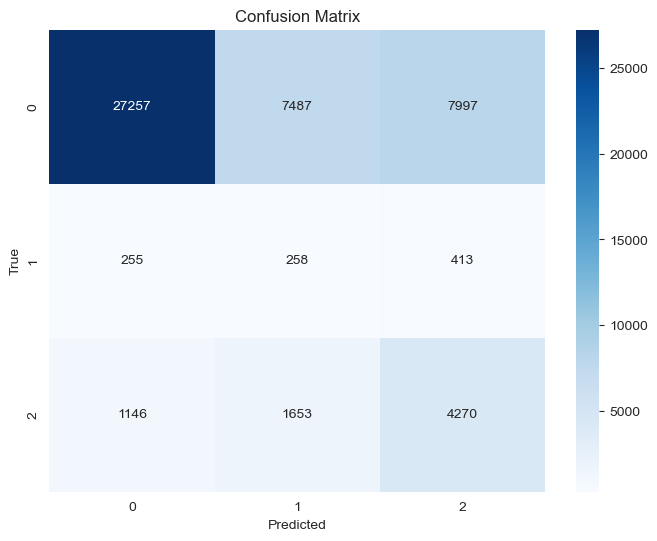

<Figure size 640x480 with 0 Axes>

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, cohen_kappa_score, log_loss,
    confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
selected_cols = multinomial(X)
if 'const' in selected_cols:
    selected_cols.remove('const')
X_model = X[selected_cols]

# === 3. TRAIN/TEST SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# === 4. SMOTE BALANCING ===
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# ==== 6. TORCH DATASET ====
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        if isinstance(X, pd.DataFrame) or isinstance(X, np.ndarray):
            X = np.array(X)
        if isinstance(y, pd.Series):
            y = y.values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DiabetesDataset(X_resampled, y_resampled)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# ==== 6. MODEL DEFINITION ====

class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        return self.model(x)

# ==== 7. FOCAL LOSS ====
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, input, target):
        logpt = -self.ce(input, target)
        pt = torch.exp(logpt)
        return -((1 - pt) ** self.gamma) * logpt

# ==== 8. MODEL SETUP ====
input_dim = X_train_scaled.shape[1]
model = DiabetesModel(input_dim)

# Compute class weights based on inverse frequency (from resampled training set)
class_counts = pd.Series(y_resampled).value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float)
weights = weights / weights.sum()

criterion = FocalLoss(gamma=1.5, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

# ==== 9. TRAINING LOOP ====
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}")

# ==== 10. EVALUATION ====
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

# ==== 11. METRICS ====
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred))

print(f"Accuracy:          {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision (macro): {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Precision (weighted): {precision_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Recall (macro):    {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall (weighted): {recall_score(y_true, y_pred, average='weighted'):.4f}")
print(f"F1-score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1-score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")
print(f"Log Loss: {log_loss(y_true, y_probs):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")

# ==== 12. CONFUSION MATRIX ====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_2.png")
plt.show()


